In [7]:
# hide
%reload_ext autoreload
%autoreload 2

In [8]:
from datetime import datetime
import json
import numpy as np
import copy
import tenseal as ts
import random
import tensorflow as tf
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import matplotlib.pyplot as plt
from make_logreg_data import *
from HE_functions import *
from dataFunction import *
from dataFunction import *
from lrClass import LR
from simulationDataUtils import *
from run_simulations import run_simulations

random.seed(11007303)
np.random.seed(2021)

In [6]:
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [11]:
cleveland = "../Data/processed.cleveland.data"
switzerland = "../Data/processed.switzerland.data"
va = "../Data/processed.va.data"
hungarian = "../Data/reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)


In [12]:
def average_state_dict_test(state_dicts, len_dict, keys):
    result = {}

    for i, state_dict in enumerate(state_dicts):
        for key in keys:
            if i == 0:
                result[key] =  state_dict[key]*(len_dict[i]/sum(len_dict))
            else:
                result[key] += state_dict[key]*(len_dict[i]/sum(len_dict))
    return result

In [13]:
def FL_proces_test(clients, validation_X_set, validation_y_set, ctx_eval, glob_model, iters, simulation= False, switzerland= False):
    loss_train = []
    net_best = None
    best_acc = None
    best_epoch = None
    results = []
    min_loss_client = []
    glob_model.eval()
    if switzerland:
        client_results = {
            'Cleveland': [],
            'Switzerland': [],
            'VA Long Beach': [],
            'Hungary': []
        }
    else:
        client_results = {
            'Cleveland': [],
            'VA Long Beach': [],
            'Hungary': []
            }
    enrypted_state_dicts= None
    acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set, simulation)

    best_acc = acc_test
    for iter in range(iters):
        loss_locals = []
        client_state_dicts = []
        client_len = []
        for client in clients:
            client_model = copy.deepcopy(glob_model)
            client.set_state_dict(client_model.state_dict())
            client_state_dict, loss = train_model_client(client, epochs=40, simulation = simulation)
            
            loss_locals.append(copy.deepcopy(loss))
            min_loss_client.append(min(loss))
            client_acc, client_loss = accuracy_loss_LR(client.model, client.X_test, client.y_test)
            new_list = client_results.get(client.name)
            new_list.append(client_acc)
            client_results[client.name] = new_list
            client_state_dicts.append(client_state_dict)
            client_len.append(len(client.y))

        enrypted_state_dicts = encrypt_state_dicts(copy.deepcopy(client_state_dicts), ctx_eval)
        averaged_encrypted_state_dict = average_state_dict_test(enrypted_state_dicts, client_len, [k for k in enrypted_state_dicts[0]])
        decrypted_state_dicts = decrypt_state_dicts(averaged_encrypted_state_dict)
        glob_model.load_state_dict(decrypted_state_dicts)

        loss_avg = sum(min_loss_client) / len(min_loss_client)
        loss_train.append(loss_avg)        
            
        acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set, simulation)

        # print('Round {:3d}, Average loss {:.3f}, Test loss {:.3f}, Test accuracy: {:.2f}'.format(
        #     iter, loss_avg, loss_test, acc_test))


        if best_acc is None or acc_test > best_acc:
            net_best = copy.deepcopy(glob_model)
            best_acc = acc_test
            best_epoch = iter

        results.append(np.array([iter, loss_avg, loss_test, acc_test, best_acc]))
        final_results = np.array(results)
        final_results = pd.DataFrame(final_results, columns=['epoch', 'loss_avg', 'loss_test', 'acc_test', 'best_acc'])

    # print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))    
    return best_epoch, best_acc, glob_model.state_dict(), final_results, client_results

In [15]:
df_dict_W ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_W = []

for i in list(df_dict_W.keys()):
    df = df_dict_W.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_W = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_W)
    lr = 0.1
    clients_W.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_W = KL_matrices_disc_cont(clients_W, cat_bin_features, numeric_feature_names)
KL_mean_W = (np.array(KL_W)[np.triu_indices(len(clients_W), k=1)].mean() + np.array(KL_W)[np.tril_indices(len(clients_W), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_W:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model = LR(len(clients_W[0].X.columns))
val_x_W, val_y_W = make_validation_sets(clients_W)

best_epoch_W, best_acc_W, model_dict_W, final_results_W, client_results_W = FL_proces_test(clients_W, val_x_W, val_y_W, ctx_eval, glob_model_W, 10, False, False)
print(df_dict_W.keys())
print(clients_W[0].X.columns)
print(KL_W)
print('KL FL mean: {}'.format(KL_mean_W))
print('Best model, iter: {}, acc: {}'.format(best_epoch_W, best_acc_W))  
for i in list(client_results_W.keys()):
    list_client = client_results_W.get(i)
    print('{} has accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))


dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2
0  0.000000  2.195766  2.487446
1  2.578414  0.000000  2.324436
2  1.562033  1.990125  0.000000
KL FL mean: 2.1897034270096745
Best model, iter: 7, acc: 0.7599999904632568
Cleveland has accuracy 0.757377028465271
Cleveland has max accuracy 0.7704917788505554
Cleveland has min accuracy 0.7377049326896667
VA Long Beach has accuracy 0.800000011920929
VA Long Beach has max accuracy 0.8666666746139526
VA Long Beach has min accuracy 0.7666666507720947
Hungary has accuracy 0.8983051180839539
Hungary has max accuracy 0.9152542352676392
Hungary has min accuracy 0.8813559412956238


In [17]:
df_dict_SW ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_SW = []

for i in list(df_dict_SW.keys()):
    df = df_dict_SW.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_SW = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_SW:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_SW = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_SW)
    lr = 0.1
    clients_SW.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_SW = KL_matrices_disc_cont(clients_SW, cat_bin_features, numeric_feature_names_SW)
KL_mean_S = (np.array(KL_SW)[np.triu_indices(len(clients_SW), k=1)].mean() + np.array(KL_SW)[np.tril_indices(len(clients_SW), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_SW:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model_S = LR(len(clients_SW[0].X.columns))
val_x_SW, val_y_SW = make_validation_sets(clients_SW)

best_epoch_SW, best_acc_SW, model_dict_SW, final_results_SW, client_results_SW = FL_proces_test(clients_SW, val_x_SW, val_y_SW, ctx_eval, glob_model_SW, 10, False, True)
print(df_dict_SW.keys())
print(clients_SW[0].X.columns)
print(KL_SW)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_SW, best_acc_SW))  
for i in list(client_results_SW.keys()):
    list_client = client_results_SW.get(i)
    print('{} has accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))


dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'FastingBS', 'MaxHR', 'ExerciseAngina',
       'Oldpeak', 'ChestPainType_1', 'ChestPainType_4', 'ChestPainType_3',
       'ChestPainType_2', 'RestingECG_2', 'RestingECG_0', 'RestingECG_1',
       'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2             3
0  0.000000  1.735963  2.183113  2.462930e+00
1  1.591768  0.000000  0.709178  1.354121e+00
2  2.558419  0.878337  0.000000  2.318305e+00
3  1.539994  1.350110  1.983839 -2.220446e-16
KL FL mean: 1.7221729711312652
Best model, iter: 9, acc: 0.7485714554786682
Cleveland has accuracy 0.8032787442207336
Cleveland has max accuracy 0.8196721076965332
Cleveland has min accuracy 0.7704917788505554
Switzerland has accuracy 0.8799999952316284
Switzerland has max accuracy 0.8799999952316284
Switzerland has min accuracy 0.8799999952316284
VA Long Beach has accuracy 0.8233333826065063
VA Long Bea

In [18]:
df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model)
    lr = 0.1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL = KL_matrices_disc_cont(clients, cat_bin_features, numeric_feature_names)
KL_mean = (np.array(KL)[np.triu_indices(len(clients), k=1)].mean() + np.array(KL)[np.tril_indices(len(clients), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model = LR(len(clients[0].X.columns))
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results , client_results = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 10, False, False)
print(df_dict.keys())
print(clients[0].X.columns)
print(KL)
print('KL FL mean: {}'.format(KL_mean))
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  
for i in list(client_results.keys()):
    list_client = client_results.get(i)
    print('{} has accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))


dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2
0  0.000000  2.195766  2.487446
1  2.578414  0.000000  2.324436
2  1.562033  1.990125  0.000000
KL FL mean: 2.1897034270096745
Best model, iter: 9, acc: 0.7866666913032532
Cleveland has accuracy 0.772131085395813
Cleveland has max accuracy 0.7868852615356445
Cleveland has min accuracy 0.7704917788505554
VA Long Beach has accuracy 0.8133333325386047
VA Long Beach has max accuracy 0.8333333134651184
VA Long Beach has min accuracy 0.800000011920929
Hungary has accuracy 0.8999999761581421
Hungary has max accuracy 0.9152542352676392
Hungary has min accuracy 0.8644067645072937


In [19]:
df_dict_S ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_S = []

for i in list(df_dict_S.keys()):
    df = df_dict_S.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_S = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_S:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    # print(y.value_counts())
    glob_model_S = LR(len(x.columns)+7)
    client_model = copy.deepcopy(glob_model_S)
    lr = 0.1
    clients_S.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(reduction='mean'), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_S = KL_matrices_disc_cont(clients_S, cat_bin_features, numeric_feature_names_S)
KL_mean_S = (np.array(KL_S)[np.triu_indices(len(clients_S), k=1)].mean() + np.array(KL_S)[np.tril_indices(len(clients_S), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_S:
    i.make_dummies(cat_feat)
    i.make_test()
glob_model_S = LR(len(clients_S[0].X.columns))
val_x_S, val_y_S = make_validation_sets(clients_S)

best_epoch_S, best_acc_S, model_dict_S, final_results_S, client_results_S = FL_proces(clients_S, val_x_S, val_y_S, ctx_eval, glob_model_S, 10, False, True)
print(df_dict_S.keys())
print(clients_S[0].X.columns)
print(KL_S)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_S, best_acc_S))  
for i in list(client_results_S.keys()):
    list_client = client_results_S.get(i)
    print('{} has mean accuracy {}'. format(i, np.mean(list_client)))
    print('{} has max accuracy {}'. format(i, np.max(list_client)))
    print('{} has min accuracy {}'. format(i, np.min(list_client)))



dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0             1         2             3
0  0.000000  1.748567e+00  2.183113  2.462930e+00
1  1.595784 -2.220446e-16  0.706801  1.349862e+00
2  2.558419  8.792501e-01  0.000000  2.318305e+00
3  1.539994  1.352187e+00  1.983839 -2.220446e-16
KL FL mean: 1.7232540815757624
Best model, iter: 1, acc: 0.5771428346633911
Cleveland has mean accuracy 0.4754098355770111
Cleveland has max accuracy 0.4754098355770111
Cleveland has min accuracy 0.4754098355770111
Switzerland has mean accuracy 0.8399999737739563
Switzerland has max accuracy 0.8399999737739563
Switzerland has min accuracy 0.8399999737739563
VA Long Beac

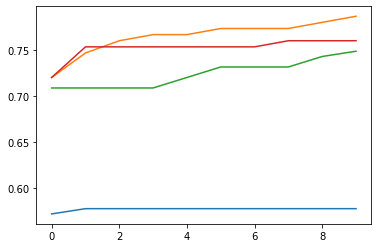

In [21]:
plt.plot(final_results_S.best_acc)
plt.plot(final_results.best_acc)
plt.plot(final_results_SW.best_acc)
plt.plot(final_results_W.best_acc)
# plt.plot(final_results_S.loss_test)
# plt.plot(final_results.loss_test)
# plt.plot(final_results_SW.loss_test)
# plt.plot(final_results_W.loss_test)
plt.show()

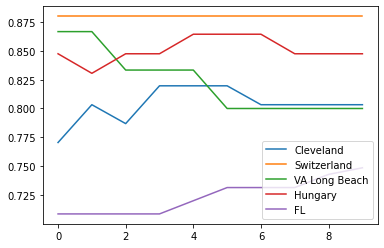

In [22]:
for i in list(client_results_SW.keys()):
    list_client = client_results_SW.get(i)
    plt.plot(list_client[0:best_epoch_SW+1], label = i)
plt.plot(final_results_SW.best_acc[0:best_epoch_SW+1], label ='FL')
plt.legend()

In [23]:
client_results_W.keys()

dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])

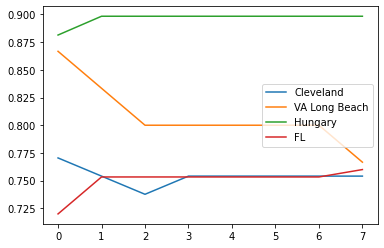

In [24]:
for i in list(client_results_W.keys()):
    list_client = client_results_W.get(i)
    plt.plot(list_client[0:best_epoch_W+1], label = i)
plt.plot(final_results_W.best_acc[0:best_epoch_W+1], label ='FL')
plt.legend()

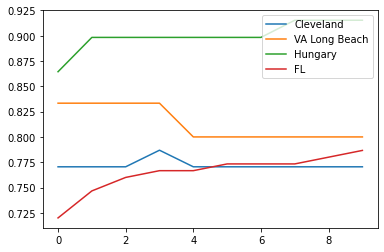

In [25]:
for i in list(client_results.keys()):
    list_client = client_results.get(i)
    plt.plot(list_client[0:best_epoch+1], label = i)
plt.plot(final_results.best_acc[0:best_epoch+1], label ='FL')
plt.legend()

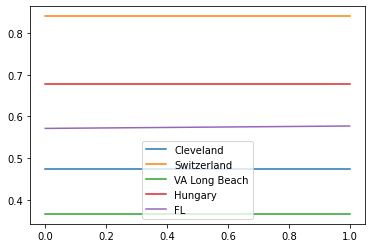

In [26]:
for i in list(client_results_S.keys()):
    list_client = client_results_S.get(i)
    plt.plot(list_client[0:best_epoch_S+1], label = i)
plt.plot(final_results_S.best_acc[0:best_epoch_S+1], label ='FL')
plt.legend()

In [27]:
pd.DataFrame(client_results_S).describe

<bound method NDFrame.describe of         Cleveland     Switzerland   VA Long Beach         Hungary
0  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
1  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
2  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
3  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
4  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
5  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
6  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
7  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
8  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)
9  tensor(0.4754)  tensor(0.8400)  tensor(0.3667)  tensor(0.6780)>

In [28]:
list_client

[tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780),
 tensor(0.6780)]

In [29]:
kl = np.empty(((len(clients_S)+1), (len(clients_S)+1)))
for i in range(len(clients_S)+1):
    for j in range(len(clients_S)+1):
        # print(j)
        if i > len(clients_S)-1 and j >  len(clients_S)-1:
             kl[i,j] = KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(val_y_S))
        elif i > len(clients_S)-1:
            # print(j)
            kl[i,j] = KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[j].y))
        elif j > len(clients_S)-1:
            kl[i,j] = KL_divergence_disc(prob_discrete_var(clients_S[i].y),prob_discrete_var(val_y_S))
        else:
            # print(i)
            kl[i,j] = KL_divergence_disc(prob_discrete_var(clients_S[i].y),prob_discrete_var(clients_S[j].y))
        
kl

array([[0.        , 0.81606373, 0.24531176, 0.01922391, 0.01833006],
       [0.5263773 , 0.        , 0.08868103, 0.73440592, 0.36233405],
       [0.21714275, 0.12425976, 0.        , 0.36420349, 0.11199057],
       [0.01877364, 1.10500787, 0.40154293, 0.        , 0.0738069 ],
       [0.01829941, 0.56473543, 0.12642981, 0.07544452, 0.        ]])

In [30]:
print(KL_divergence_disc(prob_discrete_var(clients_S[0].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(clients_S[1].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(clients_S[2].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(clients_S[3].y),prob_discrete_var(val_y_S)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[0].y)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[1].y)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[2].y)))
print(KL_divergence_disc(prob_discrete_var(val_y_S),prob_discrete_var(clients_S[3].y)))

0.018330057124611693
0.3623340544977067
0.11199057141456908
0.07380689700082108
0.018299405943864866
0.5647354345315885
0.12642981055037422
0.0754445181625738


In [31]:
clients_S

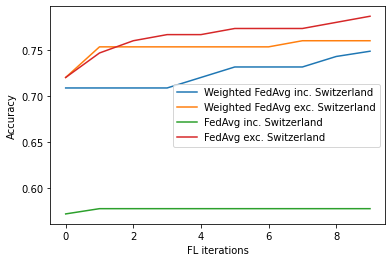

In [35]:
plt.plot(final_results_SW.best_acc[:200], label= 'Weighted FedAvg inc. Switzerland')
plt.plot(final_results_W.best_acc[:200], label= 'Weighted FedAvg exc. Switzerland')
plt.plot(final_results_S.best_acc[:200], label= 'FedAvg inc. Switzerland')
plt.plot(final_results.best_acc[:200], label= 'FedAvg exc. Switzerland')
plt.ylabel('Accuracy')
plt.xlabel('FL iterations')
plt.legend()

# plt.savefig('images/Accuracy_Healthcare_iter2000',bbox_inches='tight',  dpi=300)
# plt.savefig('/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_latex/images/Accuracy_Healthcare_iter2000', bbox_inches='tight',  dpi=300)
plt.show()

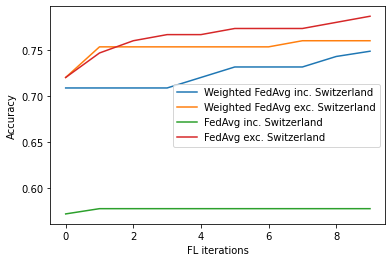

In [36]:
plt.plot(final_results_SW.best_acc[:2000], label= 'Weighted FedAvg inc. Switzerland')
plt.plot(final_results_W.best_acc[:2000], label= 'Weighted FedAvg exc. Switzerland')
plt.plot(final_results_S.best_acc[:2000], label= 'FedAvg inc. Switzerland')
plt.plot(final_results.best_acc[:2000], label= 'FedAvg exc. Switzerland')
plt.ylabel('Accuracy')
plt.xlabel('FL iterations')
plt.legend()

# plt.savefig('images/Accuracy_Healthcare',bbox_inches='tight',  dpi=300)
# plt.savefig('/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_latex/images/Accuracy_Healthcare', bbox_inches='tight',  dpi=300)
plt.show()